In [25]:
import json
from pathlib import Path

import pandas as pd

from protrend.utils import Settings

report_file_path = Path(Settings.report_working_directory).joinpath('protrend_report_2022_08_31_12_42_39.json')
with open(report_file_path, 'r') as f:
    report = json.load(f)

df = pd.DataFrame(list(report.values()))
df

,source,version,system,label,objects,properties,source_label,target_label,relationships
0,collectf,0.0.1,transform,evidence,56.0,5.0,NaN,NaN,NaN
1,collectf,0.0.1,integrate,evidence,56.0,9.0,NaN,NaN,NaN
2,collectf,0.0.1,extract,organism,153.0,7.0,NaN,NaN,NaN
3,collectf,0.0.1,transform,organism,155.0,14.0,NaN,NaN,NaN
4,collectf,0.0.1,integrate,organism,153.0,19.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
373,standardizer,0.0.0,integrate,regulatoryinteraction,139.0,1.0,NaN,NaN,NaN
374,standardizer,0.0.0,transform,evidence,104.0,1.0,NaN,NaN,NaN
375,standardizer,0.0.0,integrate,evidence,104.0,1.0,NaN,NaN,NaN
376,standardizer,0.0.0,transform,publication,16139.0,1.0,NaN,NaN,NaN


In [26]:
data = df[(df.source == 'standardizer') & (df.system == 'transform')]
data = data[['label', 'objects']].reset_index(drop=True)
data = data.set_index('label')
data = data.to_dict(orient='dict')
data = {key: [val] for key, val in data['objects'].items()}
data

{'organism': [80.0],
 'regulator': [199.0],
 'source': [1.0],
 'gene': [3448.0],
 'regulatoryfamily': [3.0],
 'effector': [69.0],
 'operon': [0.0],
 'tfbs': [2799.0],
 'pathway': [1.0],
 'regulatoryinteraction': [139.0],
 'evidence': [104.0],
 'publication': [16139.0]}

In [27]:
from protrend.utils import NeoDatabase
from protrend.model import *

# connect to database
neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [28]:
nodes = (
    Effector,
    Evidence,
    Gene,
    Operon,
    Organism,
    Pathway,
    Publication,
    Regulator,
    RegulatoryFamily,
    RegulatoryInteraction,
    Source,
    TFBS,
)

for node in nodes:
    data[node.node_name()].append(len(node.nodes))

data

{'organism': [80.0, 536],
 'regulator': [199.0, 15982],
 'source': [1.0, 11],
 'gene': [3448.0, 112493],
 'regulatoryfamily': [3.0, 200],
 'effector': [69.0, 432],
 'operon': [0.0, 24690],
 'tfbs': [2799.0, 79922],
 'pathway': [1.0, 286],
 'regulatoryinteraction': [139.0, 210848],
 'evidence': [104.0, 78],
 'publication': [16139.0, 2283]}

In [30]:
df = pd.DataFrame(data)
df = df.transpose()
df = df.rename(columns={1: 'standardized', 0: 'no standardization'})
df['no standardization'] = df['standardized'] + df['no standardization']
df = df.sort_values(by='standardized')
df

,no standardization,standardized
source,12.0,11.0
evidence,182.0,78.0
regulatoryfamily,203.0,200.0
pathway,287.0,286.0
effector,501.0,432.0
organism,616.0,536.0
publication,18422.0,2283.0
regulator,16181.0,15982.0
operon,24690.0,24690.0
tfbs,82721.0,79922.0


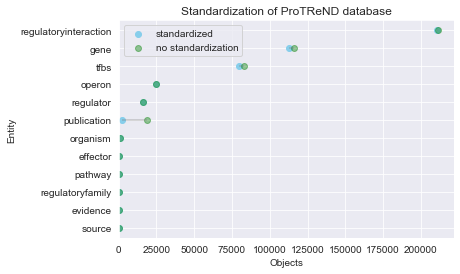

In [32]:
from matplotlib import pyplot as plt

y = range(1,len(df.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=y, xmin=df['standardized'], xmax=df['no standardization'],
           color='grey', alpha=0.4)
plt.scatter(df['standardized'], y, color='skyblue', alpha=1, label='standardized')
plt.scatter(df['no standardization'], y, color='green', alpha=0.4 , label='no standardization')
plt.legend()

plt.xlim(-1)

# Add title and axis names
plt.yticks(y, df.index)
plt.title("Standardization of ProTReND database")
plt.xlabel('Objects')
plt.ylabel('Entity')

# Show the graph
plt.savefig("standardization_report.png", bbox_inches="tight", dpi=150)
plt.show()